In [ ]:

import sys
sys.path.append("C:\\Users\\magggien\\Documents\\Masters\\QFAT\\group_project\\src")
from EDA import *
from QuantStrategy import *

In [11]:
price_data_monthtly = pd.read_csv(f'C:\\Users\\magggien\\Documents\\Masters\\QFAT\\group_project\\data\\NL_FR_BE_data_monthly.csv')
price_data_annually = pd.read_csv(f'C:\\Users\\magggien\\Documents\\Masters\\QFAT\\group_project\\data\\NL_FR_BE_data_annual.csv')
factor_data = pd.read_csv(f"C:\\Users\\magggien\\Documents\\Masters\\QFAT\\group_project\\data\\Europe_FF_Factors.csv")
firm_data = pd.read_csv(f"C:\\Users\\magggien\\Documents\\Masters\\QFAT\\group_project\\data\\NL_FR_BE_firms.csv")

In [ ]:

    
def merge_data(price_data_monthtly, price_data_annually, firm_data):
    """
    Merge the data into one dataframe
    """
    if 'ISIN' not in price_data_monthtly.columns or 'ISIN' not in firm_data.columns:
        raise KeyError("ISIN column missing in one of the datasets")

    # Merge firm data with price data
    merged_monthly = price_data_monthtly.merge(firm_data, on='ISIN', how='left')
    merged_annually = price_data_annually.merge(firm_data, on='ISIN', how='left')
    
    return merged_monthly, merged_annually

def convert_mdate(df):
    """
    Convert mdate column from format 200110 to a proper datetime column
    """
    df_copy = df.copy()
    df_copy['mdate'] = df_copy['mdate'].astype(str)
    
    # Extract year and month
    df_copy['year'] = df_copy['mdate'].str[:4].astype(int)
    df_copy['month'] = df_copy['mdate'].str[4:].astype(int)
    
    # Proper datetime column
    df_copy['date'] = pd.to_datetime(df_copy[['year', 'month']].assign(day=1))
    
    return df_copy

In [3]:
merged_monthly, merged_annually = merge_data(price_data_monthtly, price_data_annually, firm_data)
merged_monthly = convert_mdate(merged_monthly)
factor_data = convert_mdate(factor_data)

In [4]:
explorer = DataExplorer(merged_monthly, merged_annually, factor_data)
explorer.summary_statistics()
explorer.missing_values()

Price Data Monthly Summary:
                 RET          RET11             ME              b  \
count  254523.000000  254523.000000  254523.000000  254523.000000   
mean        0.010450       0.138524    3098.698223       0.925266   
min        -0.901300      -0.980900       2.161100     -14.818400   
25%        -0.048400      -0.153200      52.378750       0.650000   
50%         0.004200       0.067600     202.566000       0.897300   
75%         0.060000       0.314500    1008.544250       1.159700   
max         7.798800     102.440200  417301.488700       6.297200   
std         0.128685       0.704042   12318.868053       0.452388   

                   h              s           ivol           year  \
count  254523.000000  254523.000000  254523.000000  254523.000000   
mean        0.198129       0.710481       0.019637    2006.649615   
min       -23.934800     -10.761700       0.001400    1991.000000   
25%        -0.282700       0.312400       0.010800    2000.000000   
50%  

In [ ]:
explorer.explore_distributions(save_path=path)
explorer.correlation_heatmap(save_path=path)


Monthly Numerical Columns: ['RET', 'RET11', 'ME', 'b', 'h', 's', 'ivol']
Annual Numerical Columns: ['fyear', 'BEME', 'OP', 'INV']
Factor Numerical Columns: ['MktRF', 'SMB', 'HML', 'RF', 'WML']


In [13]:
def create_matching_fyear(monthly_data):
    """
    Create the matching fiscal year variable in monthly data
    """
    # Extract year and month from mdate
    monthly_data['year'] = monthly_data['mdate'] // 100
    monthly_data['month'] = monthly_data['mdate'] % 100
    
    # Apply the fiscal year mapping logic
    monthly_data['matching_fyear'] = np.where(
        monthly_data['month'] >= 7,  # July to December
        monthly_data['year'] - 1,    # Previous year's fiscal data
        monthly_data['year'] - 2     # Two years prior fiscal data
    )
    
    return monthly_data

def merge_annual_monthly_data(monthly_data, annual_data):
    """
    Merge annual and monthly data
    """
    # Create the matching fiscal year in monthly data
    monthly_data = create_matching_fyear(monthly_data)
    
    # Merge on ISIN and the matching fiscal year
    merged_data = pd.merge(
        monthly_data,
        annual_data,
        left_on=['ISIN', 'matching_fyear'],
        right_on=['ISIN', 'fyear'],
        how='left'
    )
    
    # Drop auxiliary columns if no longer needed
    merged_data = merged_data.drop(['year', 'month', 'matching_fyear'], axis=1)
    
    return merged_data

In [14]:
merge_annual_monthly_data = merge_annual_monthly_data(price_data_monthtly,price_data_annually)


In [15]:
merge_annual_monthly_data

,ISIN,mdate,RET,RET11,ME,b,h,s,ivol,fyear,BEME,OP,INV
0,FR0000078875,200110,-0.0376,0.1122,18.3645,0.8282,0.5718,1.1368,0.0405,2000.0,0.0370,0.4341,0.4212
1,FR0000078875,200111,-0.0444,-0.0147,17.5492,0.9049,0.7448,1.1519,0.0537,2000.0,0.0370,0.4341,0.4212
2,FR0000078875,200112,-0.0137,-0.2766,17.3088,0.8719,0.6494,1.0724,0.0129,2000.0,0.0370,0.4341,0.4212
3,FR0000078875,200201,0.0942,-0.1528,18.9398,0.7106,0.1540,1.2666,0.0652,2000.0,0.0370,0.4341,0.4212
4,FR0000078875,200202,0.0276,-0.0070,19.4618,0.7908,0.2841,1.3323,0.0371,2000.0,0.0370,0.4341,0.4212
...,...,...,...,...,...,...,...,...,...,...,...,...,...
254518,FR0000039539,200410,-0.0711,0.4320,99.6765,1.0355,-0.8873,1.2946,0.0248,2003.0,0.3525,0.5873,0.1316
254519,FR0000039539,200411,0.1840,0.4724,118.0193,1.1269,-0.2657,1.6819,0.0489,2003.0,0.3525,0.5873,0.1316
254520,FR0000039539,200412,0.0089,0.2307,119.0678,1.1259,-0.3633,1.8243,0.0097,2003.0,0.3525,0.5873,0.1316
254521,FR0000039539,200501,-0.0214,0.0930,116.5239,1.0151,-1.3699,1.1028,0.0064,2003.0,0.3525,0.5873,0.1316


In [16]:
factor_data['mdate'] = factor_data['mdate'].astype(int)


In [42]:
merge_annual_monthly_data_ff = pd.merge(
        merge_annual_monthly_data,
        factor_data,
        left_on=['mdate'],
        right_on='mdate',
        how='left'
    )

In [19]:
merge_annual_monthly_data_ff.head()

,ISIN,mdate,RET,RET11,ME,b,h,s,ivol,fyear,BEME,OP,INV,MktRF,SMB,HML,RF,WML
0,FR0000078875,200110,-0.0376,0.1122,18.3645,0.8282,0.5718,1.1368,0.0405,2000.0,0.037,0.4341,0.4212,0.0324,0.0179,-0.0329,0.0022,-0.0666
1,FR0000078875,200111,-0.0444,-0.0147,17.5492,0.9049,0.7448,1.1519,0.0537,2000.0,0.037,0.4341,0.4212,0.0409,0.0180,-0.0110,0.0017,-0.0967
2,FR0000078875,200112,-0.0137,-0.2766,17.3088,0.8719,0.6494,1.0724,0.0129,2000.0,0.037,0.4341,0.4212,0.0182,-0.0183,0.0140,0.0015,0.0273
3,FR0000078875,200201,0.0942,-0.1528,18.9398,0.7106,0.1540,1.2666,0.0652,2000.0,0.037,0.4341,0.4212,-0.0470,0.0294,0.0183,0.0014,0.0597
4,FR0000078875,200202,0.0276,-0.0070,19.4618,0.7908,0.2841,1.3323,0.0371,2000.0,0.037,0.4341,0.4212,0.0041,-0.0035,0.0174,0.0013,0.0594


In [21]:
final_dataset = pd.merge(
        merge_annual_monthly_data_ff,
        firm_data,
        left_on=['ISIN'],
        right_on='ISIN',
        how='left'
    )
final_dataset.head()

,ISIN,mdate,RET,RET11,ME,b,h,s,ivol,fyear,...,OP,INV,MktRF,SMB,HML,RF,WML,name,country,dscode
0,FR0000078875,200110,-0.0376,0.1122,18.3645,0.8282,0.5718,1.1368,0.0405,2000.0,...,0.4341,0.4212,0.0324,0.0179,-0.0329,0.0022,-0.0666,RICHEL GROUP,FR,13267E
1,FR0000078875,200111,-0.0444,-0.0147,17.5492,0.9049,0.7448,1.1519,0.0537,2000.0,...,0.4341,0.4212,0.0409,0.0180,-0.0110,0.0017,-0.0967,RICHEL GROUP,FR,13267E
2,FR0000078875,200112,-0.0137,-0.2766,17.3088,0.8719,0.6494,1.0724,0.0129,2000.0,...,0.4341,0.4212,0.0182,-0.0183,0.0140,0.0015,0.0273,RICHEL GROUP,FR,13267E
3,FR0000078875,200201,0.0942,-0.1528,18.9398,0.7106,0.1540,1.2666,0.0652,2000.0,...,0.4341,0.4212,-0.0470,0.0294,0.0183,0.0014,0.0597,RICHEL GROUP,FR,13267E
4,FR0000078875,200202,0.0276,-0.0070,19.4618,0.7908,0.2841,1.3323,0.0371,2000.0,...,0.4341,0.4212,0.0041,-0.0035,0.0174,0.0013,0.0594,RICHEL GROUP,FR,13267E


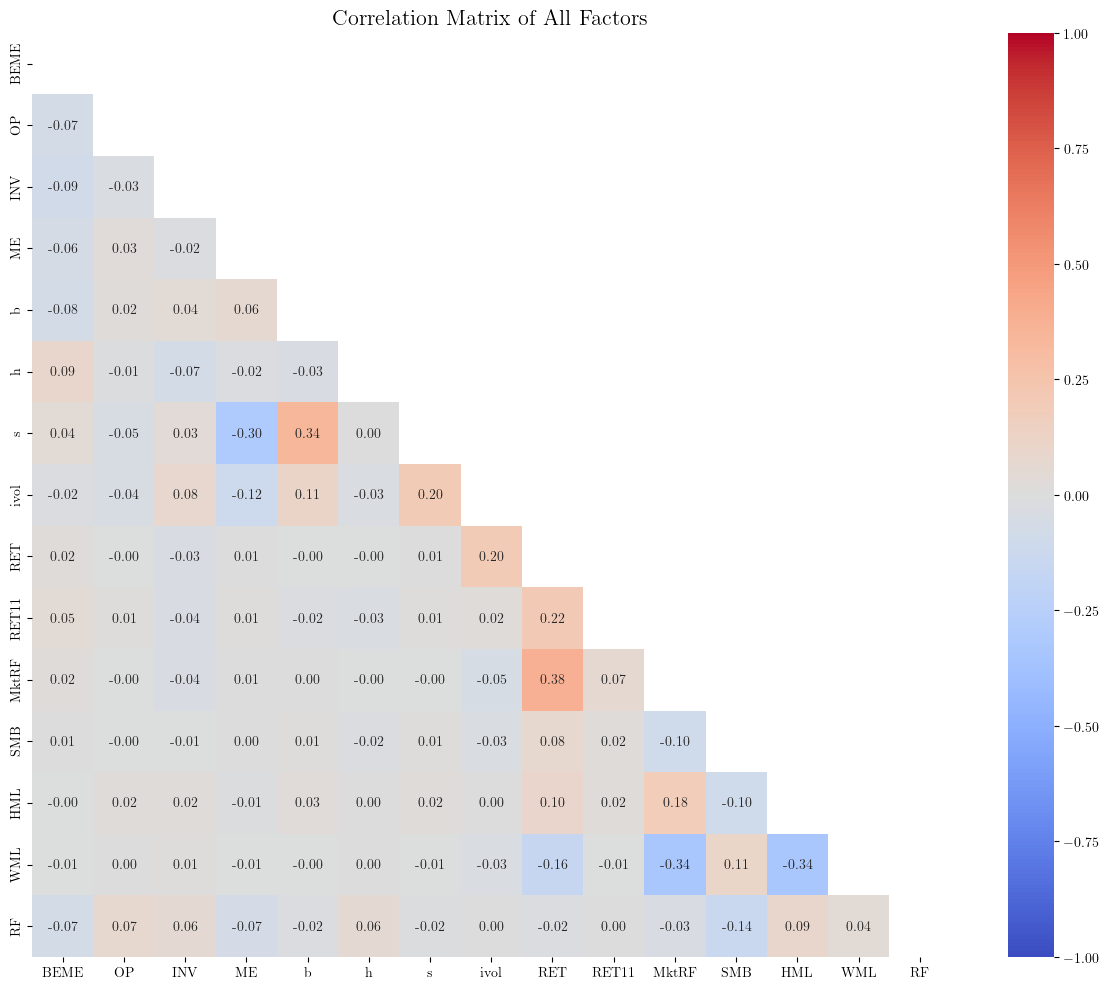

In [ ]:
factor_groups = {
        'Stock Characteristics': ['BEME', 'OP', 'INV', 'ME', 'b', 'h', 's', 'ivol'],
        'Return Measures': ['RET', 'RET11'],
        'Market Factors': ['MktRF', 'SMB', 'HML', 'WML', 'RF']
    }
    
path = "C:\\Users\\magggien\\Documents\\Masters\\QFAT\\group_project\\results"
all_factors = []
for group in factor_groups.values():
    all_factors.extend(group)
    
all_factors = list(dict.fromkeys(all_factors))
corr_matrix = final_dataset[all_factors].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Create mask for upper triangle
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            vmin=-1, vmax=1, mask=mask, fmt=".2f")
plt.title('Correlation Matrix of All Factors', fontsize=16)
plt.tight_layout()
plt.savefig(f"{path}\\correlation_matrix_all_factors.png")
plt.show()

<Figure size 1000x800 with 0 Axes>

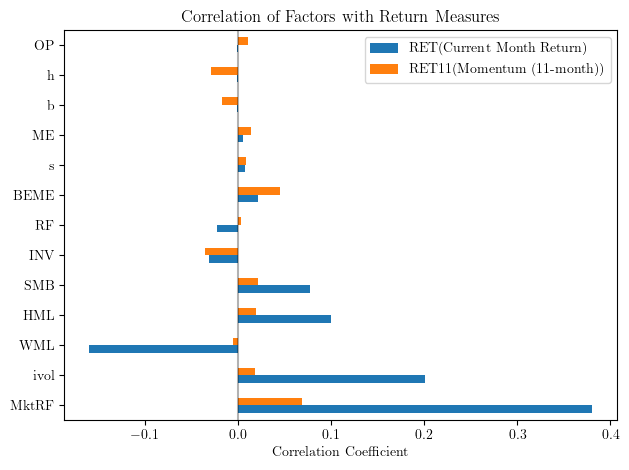

In [53]:
non_return_factors = [factor for factor in all_factors if factor not in ['RET', 'RET11']]

# Then calculate correlations
ret_correlations = pd.DataFrame({
    'RET(Current Month Return)': [final_dataset[factor].corr(final_dataset['RET']) for factor in non_return_factors],
    'RET11(Momentum (11-month))': [final_dataset[factor].corr(final_dataset['RET11']) for factor in non_return_factors]
}, index=non_return_factors)

# Sort by absolute correlation with current month return
ret_correlations = ret_correlations.sort_values(by='RET(Current Month Return)', key=abs, ascending=False)
 
# Plot correlations with returns
plt.figure(figsize=(10, 8))
ret_correlations.plot(kind='barh')
plt.title('Correlation of Factors with Return Measures')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.savefig(f"{path}\\correlation_with_returns.png")
plt.show()

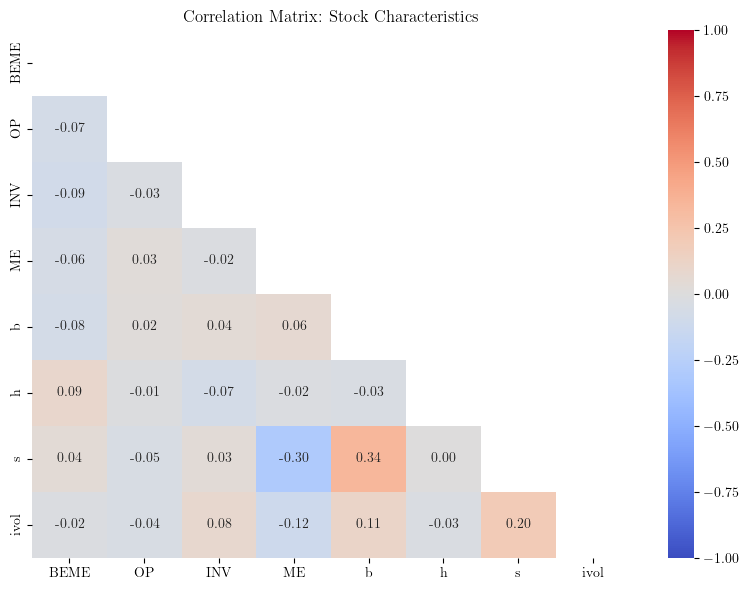

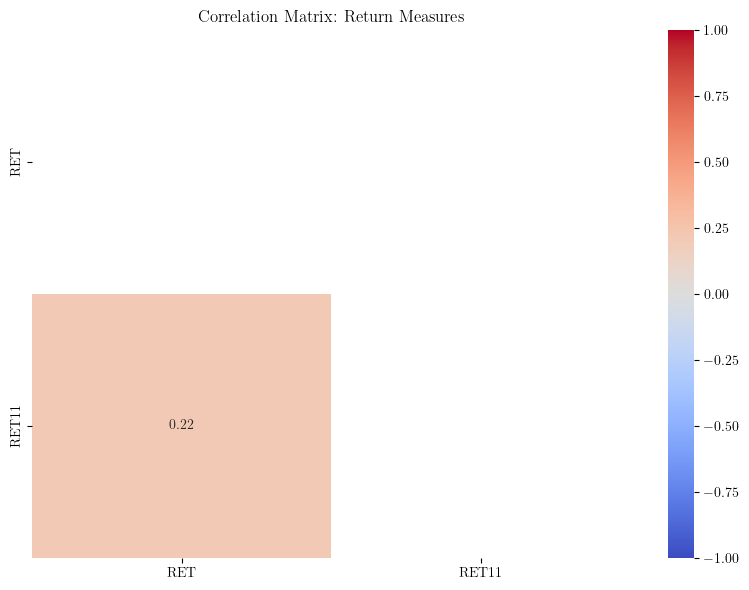

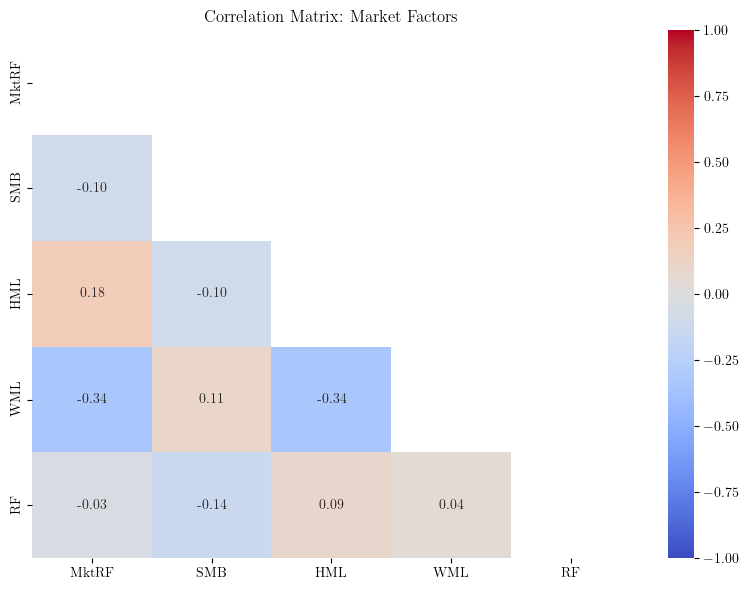

In [55]:
# 5. Calculate correlations within specific factor groups
for group_name, factors in factor_groups.items():
    if len(factors) > 1:  # Only create heatmaps for groups with at least 2 factors
        plt.figure(figsize=(8, 6))
        group_corr = final_dataset[factors].corr()
        mask = np.triu(np.ones_like(group_corr, dtype=bool))
        sns.heatmap(group_corr, annot=True, cmap='coolwarm', center=0,mask=mask, 
                    vmin=-1, vmax=1, fmt=".2f")
        plt.title(f'Correlation Matrix: {group_name}')
        plt.tight_layout()
        plt.savefig(f"{path}\\correlation_matrix_{group_name}.png")
        plt.show()

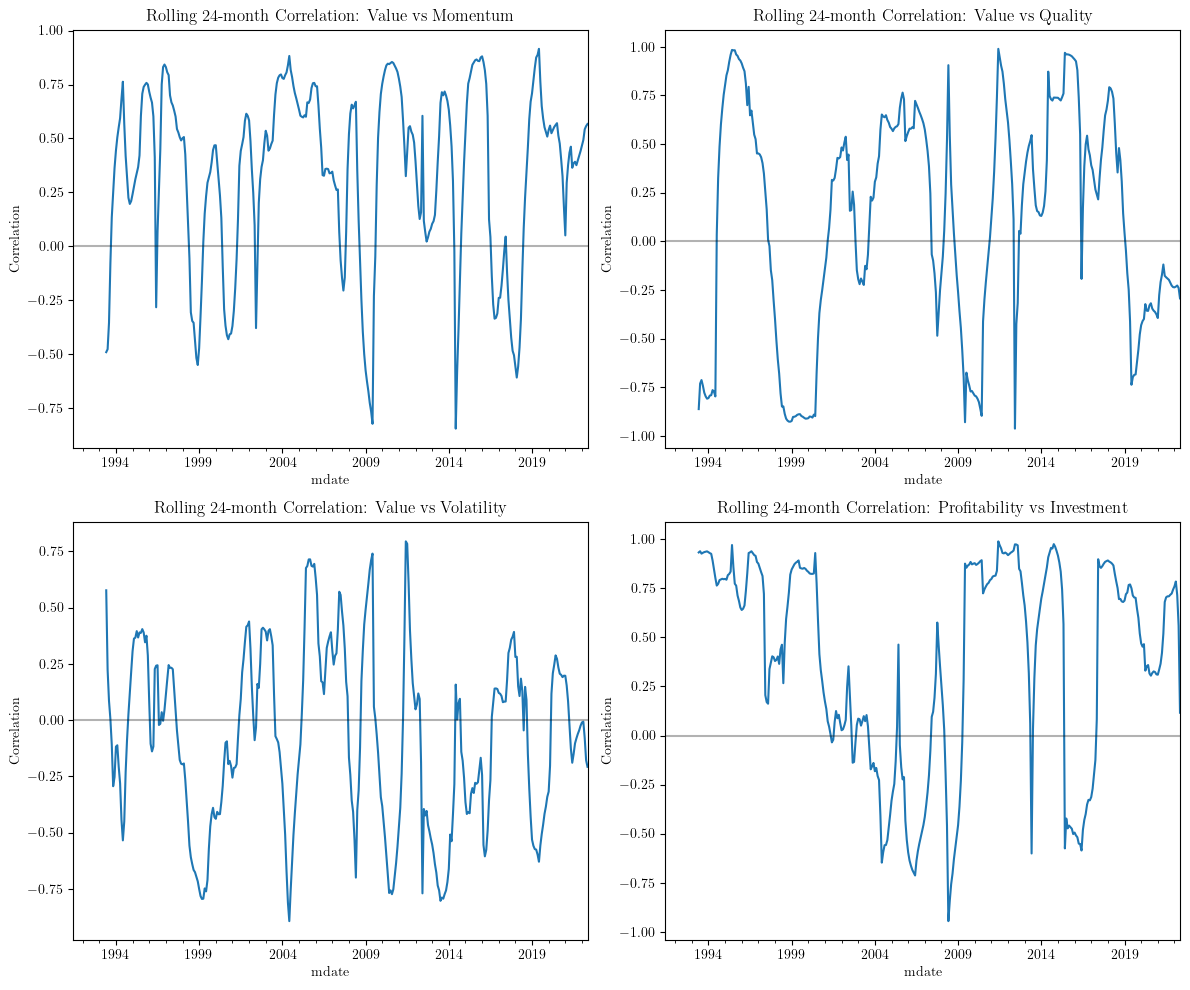

In [61]:
# 6. Analyze time-varying correlations between key factor pairs
# We'll focus on value and momentum as highlighted in the slides
key_pairs = [
    ('BEME', 'RET11', 'Value vs Momentum'),
    ('BEME', 'OP', 'Value vs Quality'),
    ('BEME', 'ivol', 'Value vs Volatility'),
    ('OP', 'INV', 'Profitability vs Investment')
]

# Convert mdate to datetime if not already
if 'mdate' in final_dataset.columns:
    if not pd.api.types.is_datetime64_any_dtype(final_dataset['mdate']):
        final_dataset['mdate'] = pd.to_datetime(final_dataset['mdate'].astype(str), format='%Y%m')

# Calculate rolling correlations by time
plt.figure(figsize=(12, 10))

for i, (factor1, factor2, title) in enumerate(key_pairs):
    # Calculate average values by month
    monthly_data = final_dataset.groupby('mdate')[[factor1, factor2]].mean()
    
    # Calculate rolling 24-month correlation
    if len(monthly_data) >= 24:  # Only if we have enough data
        roll_corr = monthly_data[factor1].rolling(24).corr(monthly_data[factor2])
        
        plt.subplot(2, 2, i+1)
        roll_corr.plot()
        plt.title(f'Rolling 24-month Correlation: {title}')
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        plt.ylabel('Correlation')

plt.tight_layout()
plt.savefig(f"{path}\\rolling_correlations.png")
plt.show()